#reference for which logistic solver to use
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
raw_data = pd.read_csv('Smarket.csv',index_col=0, parse_dates=True)
Smarket = raw_data.copy()
#initial metrics
Smarket.columns
Smarket.shape
Smarket.describe(include='all')
Smarket.head()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


#### Correlations

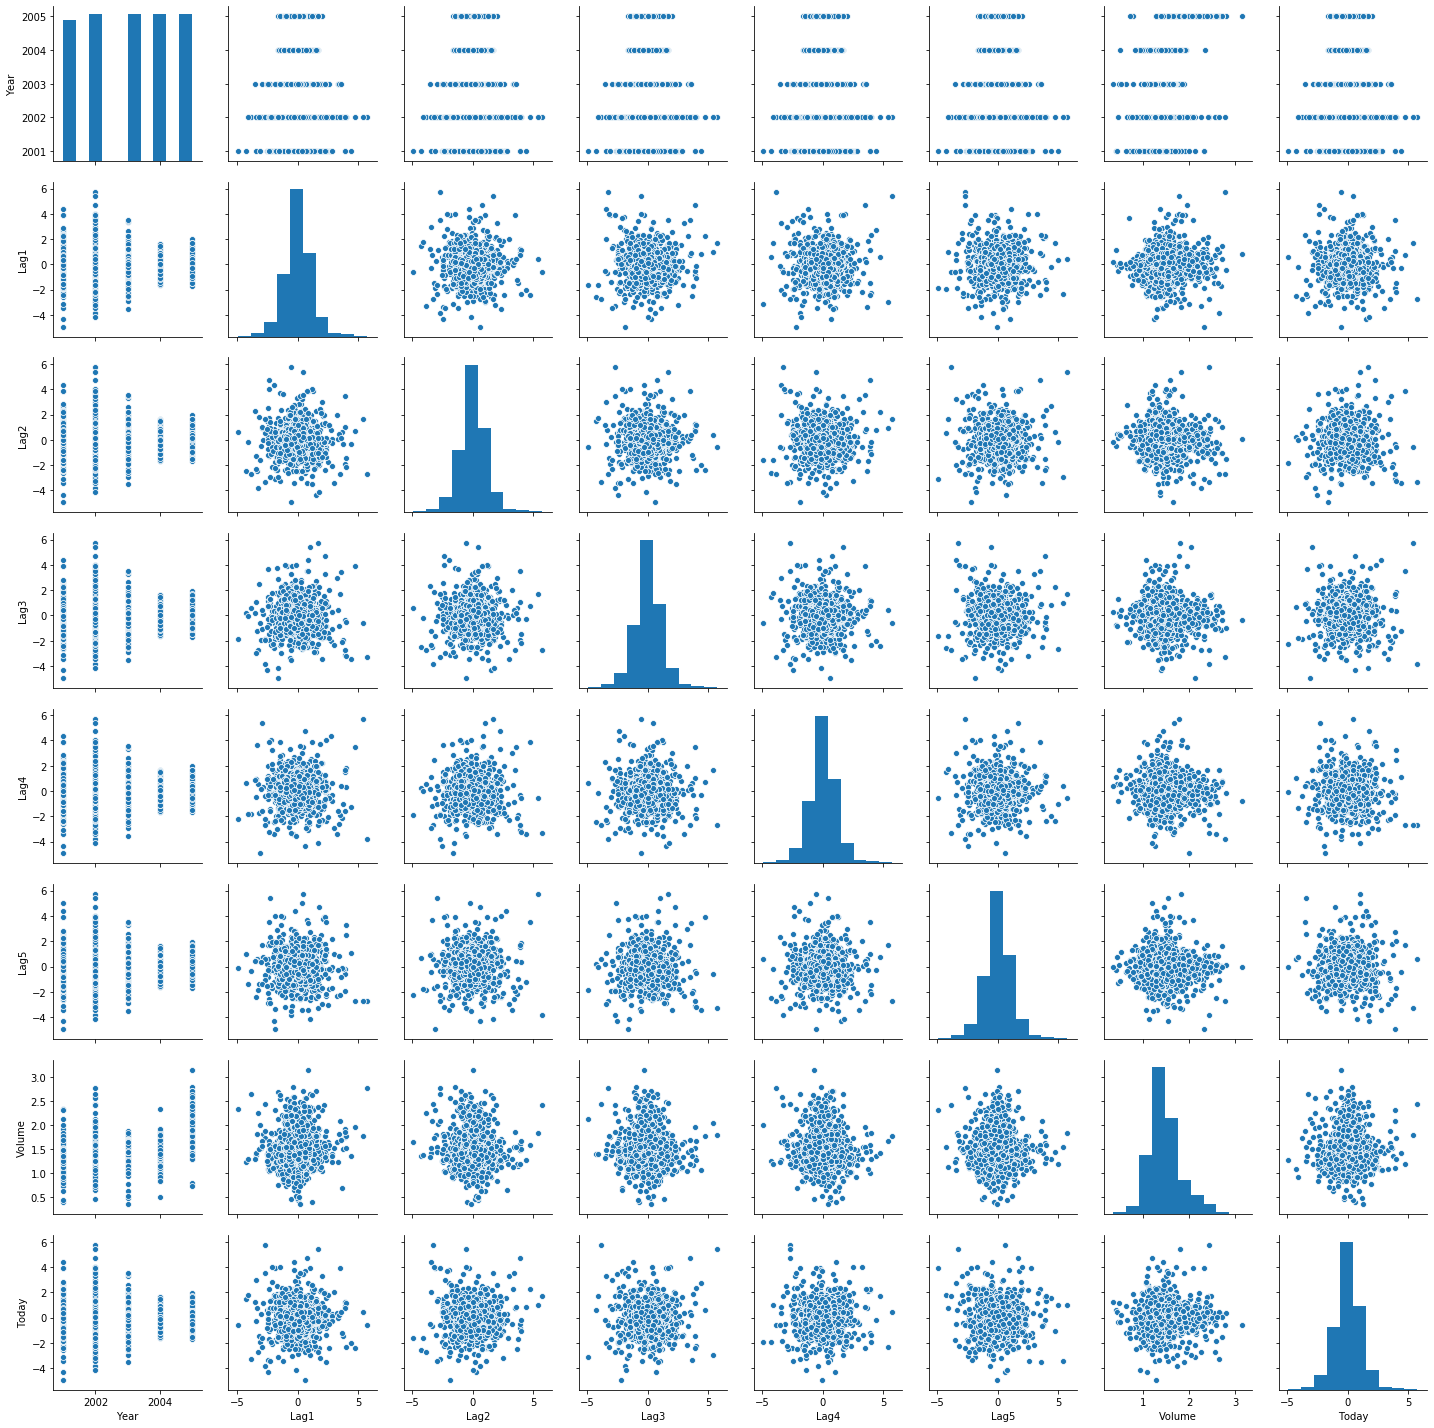

In [8]:
sns.pairplot(Smarket)

In [104]:
cm = Smarket.corr()
cm

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Lag1,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


In [15]:
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
mask = ~mask

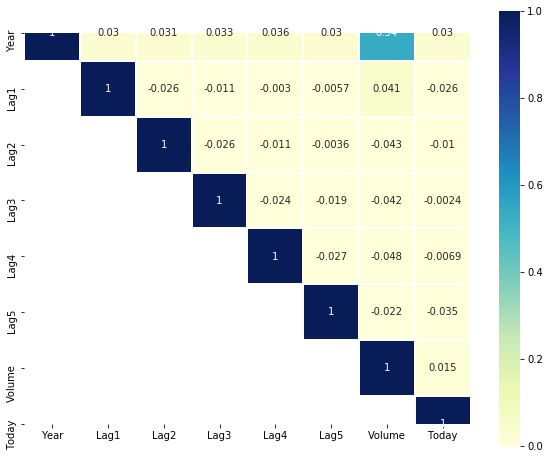

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, mask=mask, vmin=0, vmax=1, linewidths=1, cmap='YlGnBu', square=True)
plt.show()

## 4.6.2 Logistic Regression

In [31]:
#regression Direction onto Lags+Volume
var = [x for x in Smarket.columns if 'Lag' in x]
var.append('Volume')
formula = 'Direction~' + '+'.join(var)
m1 = smf.glm(formula=formula, data=Smarket, family=sm.families.Binomial())
result = m1.fit()
result.summary()

In [39]:
#isolate fields from the result 
result.params #coefficients
result.pvalues
result.model.endog_names #dependent var 

['Direction[Down]', 'Direction[Up]']

In [41]:
#predictions will give you probabilities --> need to be converted
predictions = result.predict()
predictions[0:10]

array([0.49291587, 0.51853212, 0.51886117, 0.48477764, 0.48921884,
       0.49304354, 0.50734913, 0.49077084, 0.48238647, 0.51116222])

In [55]:
#to see the encoding: 
#convert Smarket["Direction"] to an array 
#and join with dependent var 
a = Smarket.as_matrix(columns=["Direction"]).flatten()
b = result.model.endog
np.column_stack((a,b))
#we see that up=0 and down=1

C:\Users\chocovivs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


array([['Up', 0.0],
       ['Up', 0.0],
       ['Down', 1.0],
       ...,
       ['Up', 0.0],
       ['Down', 1.0],
       ['Down', 1.0]], dtype=object)

In [72]:
#convert predictions into Up/Down
predictions_nominal = ["Up" if x <0.5 else "Down" for x in predictions]
predictions_nominal

np.column_stack((predictions, predictions_nominals))

array([['0.4929158665369997', 'Up'],
       ['0.5185321218248302', 'Down'],
       ['0.518861165186862', 'Down'],
       ...,
       ['0.46073170047652534', 'Up'],
       ['0.473881709603119', 'Up'],
       ['0.482083438039207', 'Up']], dtype='<U32')

#### Confusion matrix

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(Smarket["Direction"], predictions_nominal)

#diagonal are the correct predictions 
# (145+507)/1250 = 0.5216 --- precited the movement of market 52.2% of time 

array([[145, 457],
       [141, 507]], dtype=int64)

In [88]:
target_names = ['class0 - Up', 'class1 - Down']
print(classification_report(Smarket["Direction"], predictions_nominal, target_names=target_names, digits=3))

#training error rate = 0.478

               precision    recall  f1-score   support

  class0 - Up      0.507     0.241     0.327       602
class1 - Down      0.526     0.782     0.629       648

     accuracy                          0.522      1250
    macro avg      0.516     0.512     0.478      1250
 weighted avg      0.517     0.522     0.483      1250



### creating training vs test set

In [114]:
#to split data by Year, must exclude it from the df??? 
df = pd.read_csv('Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df.describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [124]:
x_train = df[:'2004'][:]
y_train = df[:'2004']['Direction']

x_test = df['2005':][:]
y_test = df['2005':]['Direction']

In [127]:
#train on training data 
m2 = smf.glm(formula=formula, data=x_train, family = sm.families.Binomial())
result = m2.fit()

In [130]:
#test on test data
predictions = result.predict(x_test)
predictions_nominal = ["Up" if x<0.5 else "Down" for x in predictions]
print(classification_report(y_test, predictions_nominal, digits=3))

              precision    recall  f1-score   support

        Down      0.443     0.694     0.540       111
          Up      0.564     0.312     0.402       141

    accuracy                          0.480       252
   macro avg      0.503     0.503     0.471       252
weighted avg      0.511     0.480     0.463       252



In [140]:
#what if we just used Lag1 and Lag2? 

var2 = 'Direction ~ +' + '+'.join(['Lag1', 'Lag2'])
m3 = smf.glm(formula=var2, data=x_train, family=sm.families.Binomial())
result = m3.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                  998
Model:                                              GLM   Df Residuals:                      995
Model Family:                                  Binomial   Df Model:                            2
Link Function:                                    logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -690.70
Date:                                  Thu, 09 Apr 2020   Deviance:                       1381.4
Time:                                          13:32:25   Pearson chi2:                     998.
No. Iterations:                                       4                                         
Covariance Type:                              nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0322      0.063     -0.508      0.611      -0.156       0.092
Lag1           0.0556      0.052      1.076      0.282      -0.046       0.157
Lag2           0.0445      0.052      0.861      0.389      -0.057       0.146
==============================================================================
"""

In [146]:
predictions = result.predict(x_test)
pred_binomial = ["Up" if x<0.5 else "Down" for x in predictions]
print(classification_report(y_test, pred_binomial, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [151]:
#predicting particular values of lag1 & lag2 
new = pd.DataFrame([[1.2,1.1],[1.5,-0.8]], columns = ["Lag1","Lag2"])
result.predict(new)

0    0.520854
1    0.503906
dtype: float64

## 4.6.5 K-Nearest Neighbors 

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
df = pd.read_csv('Smarket.csv', usecols = range(1,10), index_col = 0, parse_dates= True)

In [9]:
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [14]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']
X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

In [64]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
pred_prob = knn.predict_proba(X_test)

In [69]:
#see how 0's and 1's are coded -- 
a = pred_prob[:,1]
b = pred
np.column_stack((a,b))

array([[0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.0, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.3333333333333333, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [1.0, 'Up'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.6666666666666666, 'Up'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.3333333333333333, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.3333333333333333, 'Down'],
       [0.6666666666666666, 'Up'],
       [0.33333333333333

In [77]:
#how to manually create the predictions 

mypred = ["Up" if x>0.9 else "Down" for x in pred_prob[:,1]]
np.column_stack((a,b,mypred))

array([[0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.0, 'Down', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [1.0, 'Up', 'Up'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.6666666666666666, 'Up', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333333, 'Down', 'Down'],
       [0.3333333333333

In [70]:
#plotting cm https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

cm = confusion_matrix(y_test, pred)
print(cm)
cm_df = pd.DataFrame(cm)
print(cm_df)
cm_df.columns = ['Predicted Down', 'Predicted Up']
cm_df = cm_df.rename(index={0: 'Actual Down', 1:'Actual Up'})
print(cm_df)

[[48 63]
 [55 86]]
    0   1
0  48  63
1  55  86
             Predicted Down  Predicted Up
Actual Down              48            63
Actual Up                55            86


In [71]:
target_names = ['0-Down', '1-Up']
print(classification_report(y_test, pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      0-Down      0.466     0.432     0.449       111
        1-Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



In [62]:
#loop through K-values to see if you get an improvement 

for k_val in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k_val)
    pred = knn.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, pred, digits=3))

#k=3 seems like the best 

              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252

              precision    recall  f1-score   support

        Down      0.443     0.667     0.532       111
          Up      0.565     0.340     0.425       141

    accuracy                          0.484       252
   macro avg      0.504     0.504     0.479       252
weighted avg      0.511     0.484     0.472       252

              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252

              preci

## 4.6.6 Application to Caravan Insurance Data

In [82]:
df2 = pd.read_csv('Caravan.csv')
df2["Purchase"].value_counts() #only 6% of dataset Yes 

No     5474
Yes     348
Name: Purchase, dtype: int64

In [89]:
#identify y and x
#standardize x 
# split into train/test

y = df2.Purchase
X_unscaled = df2.drop('Purchase', axis=1).astype('float64')

from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
my_scaler.fit(X_unscaled)
X = my_scaler.transform(X_unscaled)
print(np.std(X)) #every column has a std of 1 

0.9999999999999999


In [91]:
from sklearn.model_selection import train_test_split

In [135]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=20)


In [98]:
from sklearn.neighbors import KNeighborsClassifier

In [136]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

In [137]:
pred_proba = knn.predict_proba(x_test)
my_pred = ['Yes' if x>0.25 else 'No' for x in pred_proba[:,1]]
np.column_stack((pred, my_pred, pred_proba[:,1]))

array([['No', 'No', 0.0],
       ['No', 'No', 0.0],
       ['No', 'No', 0.0],
       ...,
       ['No', 'No', 0.0],
       ['No', 'No', 0.0],
       ['No', 'No', 0.0]], dtype=object)

In [138]:
cm = confusion_matrix(y_test, my_pred)

In [139]:
cm_df = pd.DataFrame(cm)
cm_df.columns=['pred0', 'pred1']
cm_df = cm_df.rename(index={0:'Actual0', 1:'Actual1'})
cm_df

,pred0,pred1
Actual0,928,169
Actual1,51,17


In [134]:
for kval in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=kval)
    pred = knn.fit(x_train, y_train).predict(x_test)
    print(classification_report(y_test,pred,target_names=['no','yes'], digits=3))

              precision    recall  f1-score   support

          no      0.946     0.928     0.937       941
         yes      0.117     0.153     0.132        59

    accuracy                          0.882      1000
   macro avg      0.531     0.540     0.535      1000
weighted avg      0.897     0.882     0.889      1000

              precision    recall  f1-score   support

          no      0.940     0.990     0.965       941
         yes      0.000     0.000     0.000        59

    accuracy                          0.932      1000
   macro avg      0.470     0.495     0.482      1000
weighted avg      0.885     0.932     0.908      1000

              precision    recall  f1-score   support

          no      0.945     0.979     0.961       941
         yes      0.200     0.085     0.119        59

    accuracy                          0.926      1000
   macro avg      0.572     0.532     0.540      1000
weighted avg      0.901     0.926     0.912      1000

              preci

C:\Users\chocovivs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          no      0.941     1.000     0.970       941
         yes      0.000     0.000     0.000        59

    accuracy                          0.941      1000
   macro avg      0.470     0.500     0.485      1000
weighted avg      0.885     0.941     0.912      1000

              precision    recall  f1-score   support

          no      0.942     1.000     0.970       941
         yes      1.000     0.017     0.033        59

    accuracy                          0.942      1000
   macro avg      0.971     0.508     0.502      1000
weighted avg      0.945     0.942     0.915      1000

